# Visualization of individual patients with MI

In [377]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
import sys 

sys.path.append("../")
from utils.encoding import *

from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis

from sklearn.model_selection import StratifiedKFold


In [378]:
def approximate_integral(survival_probabilities, time_points):
    # Calculate time steps for each interval
    time_steps = np.diff(time_points)
    survival_probabilities_mid = (survival_probabilities[:-1] + survival_probabilities[1:]) / 2
    # Perform the integration using the trapezoidal rule
    return np.sum(survival_probabilities_mid * time_steps)



In [379]:
M = 50

alpha = 3
l1_ratio = 0.01
n_estimators = 10
learning_rate = 0.6
subsample = 0.6

coef_by_dataset = {}
preds_cgb_mean_by_dataset = {}


patient_patnos_filtered = [9007, 9024, 9065, 9040]   # Dette er pasientene vi skal plotte!

coxnet = CoxnetSurvivalAnalysis(alphas = [alpha],
                                l1_ratio = l1_ratio,
                                fit_baseline_model = True)
cgb = ComponentwiseGradientBoostingSurvivalAnalysis(n_estimators = n_estimators, 
                                                    learning_rate = learning_rate,
                                                    subsample = subsample)

mcv = StratifiedKFold(n_splits = 5,
                      shuffle = True,
                      random_state = 173637)

survival_probabilities_coxnet_multiple = []
survival_times_coxnet_multiple = []

survival_probabilities_cgb_multiple = []
survival_times_cgb_multiple = []

for m in range(1, M+1):
    file_path = f'../../data/R/MI/new_study/new_studyM{m}.csv'
    df = pd.read_csv(file_path, sep=',', index_col=0)    
    df.index = df['PATNO']
    df = df.drop('PATNO', axis=1)
    #df = df.drop('SRI', axis = 1) 

    X, y, tuple_y, target_columns = x_y_multiple(df)  #kan sette train_df her

    survival_probabilities_coxnet = []
    survival_times_coxnet = []

    survival_probabilities_cgb = []
    survival_times_cgb = []

    for patient_index, patient_patno in enumerate(patient_patnos_filtered):

        # Cross-validation and prediction for Coxnet model
        for i, (train, test) in enumerate(mcv.split(X, tuple_y)):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y[train], y[test]

            X_train, X_test = Preprocessing_without_imputing(X_train=X_train, X_test=X_test, y_train=y_train, target_columns=target_columns)
                
            coxnet.fit(X_train, y_train)
            if patient_patno in X_test.index:
                patient_data = X_test.loc[[patient_patno]]
                surv_func = coxnet.predict_survival_function(patient_data)
                survival_probabilities_coxnet.append(surv_func[0].y)
                survival_times_coxnet.append(surv_func[0].x)

        # Cross-validation and prediction for CGB model
        for i, (train, test) in enumerate(mcv.split(X, tuple_y)):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y[train], y[test]

            X_train, X_test = Preprocessing(X_train=X_train, X_test=X_test, y_train=y_train, target_columns=target_columns)
                
            cgb.fit(X_train, y_train)
            if patient_patno in X_test.index:
                patient_data = X_test.loc[[patient_patno]]
                surv_func = cgb.predict_survival_function(patient_data)
                survival_probabilities_cgb.append(surv_func[0].y)
                survival_times_cgb.append(surv_func[0].x)


    survival_probabilities_coxnet_multiple.append(survival_probabilities_coxnet)
    survival_times_coxnet_multiple.append(survival_times_coxnet)

    survival_probabilities_cgb_multiple.append(survival_probabilities_cgb)
    survival_times_cgb_multiple.append(survival_times_cgb)

In [380]:
def pool_survival(data):
    """
    Take the average of 1,..,M datasets across the N patients.
    """

    # Number of patients
    N = len(data[0])

    # Initialize the result lists
    average_times_by_patient = []
    std_times_by_patient = []

    # Iterate over each patient
    for i in range(N):
        sums = {}
        counts = {}
        all_values = {}

        # Collect survival times for this patient across all outer lists
        for j in range(len(data)):
            if i < len(data[j]):
                for k, time in enumerate(data[j][i]):
                    if k not in sums:
                        sums[k] = 0
                        counts[k] = 0
                        all_values[k] = []
                    sums[k] += time
                    counts[k] += 1
                    all_values[k].append(time)

        # Compute the average for each time point
        avg_times = [sums[k] / counts[k] for k in sorted(sums)]
        std_times = [
            math.sqrt(sum((x - avg_times[k]) ** 2 for x in all_values[k]) / counts[k])
            for k in sorted(all_values)
        ]
        
        average_times_by_patient.append(avg_times)
        std_times_by_patient.append(std_times)
    
    pooled = {"mean": average_times_by_patient,
              "std": std_times_by_patient}

    return pooled


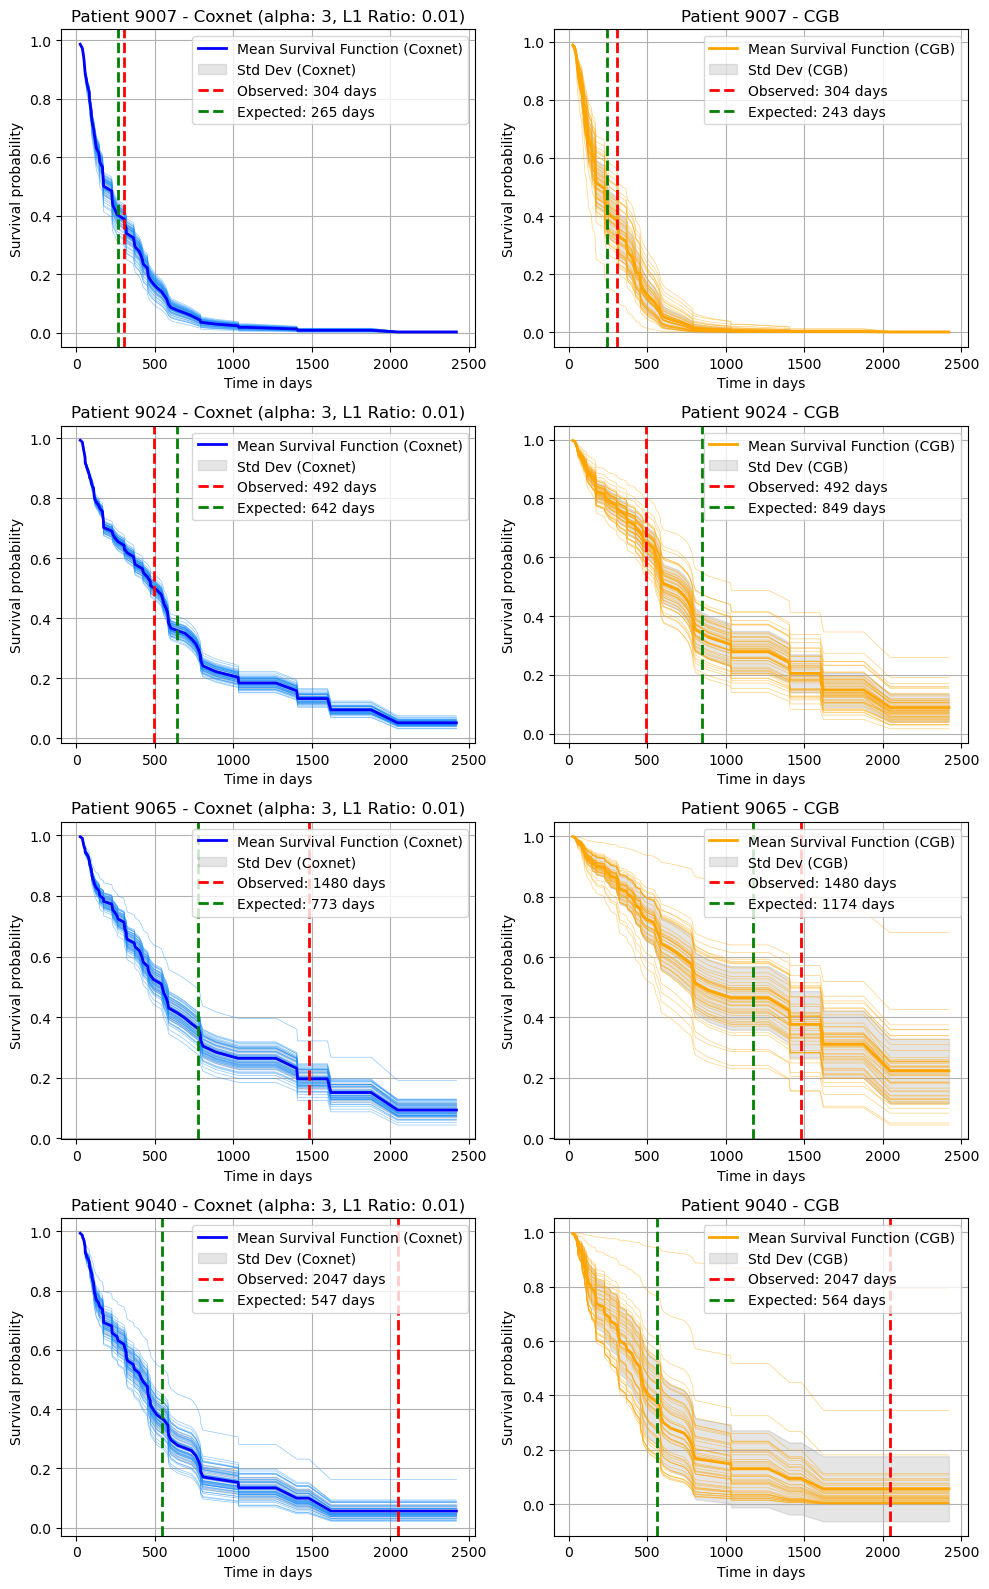

In [385]:
# Plot configuration
n_cols = 2
n_rows = len(patient_patnos_filtered)
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

mean_coxnet, std_coxnet = pool_survival(survival_probabilities_coxnet_multiple).values()
mean_cgb, std_cgb = pool_survival(survival_probabilities_cgb_multiple).values()

# Plotting Coxnet
for patient_index, patient_patno in enumerate(patient_patnos_filtered):
    for m in range(M):
        survival_probabilities_coxnet = survival_probabilities_coxnet_multiple[m]
        survival_times_coxnet = survival_times_coxnet_multiple[m]
        observed_event_time = df['time'].loc[patient_patno]
        individual_survival_time_coxnet = survival_times_coxnet[patient_index]
        individual_survival_prob_coxnet = survival_probabilities_coxnet[patient_index]

        ax = plt.subplot(n_rows, n_cols, patient_index * n_cols + 1)

        plt.plot(individual_survival_time_coxnet, individual_survival_prob_coxnet, color='dodgerblue', linewidth=0.5, alpha=0.5)

        individual_means = np.array(mean_coxnet[patient_index])
        individual_std = np.array(std_coxnet[patient_index])
        common_times = np.array(individual_survival_time_coxnet)
        
        expected_survival_time = approximate_integral(individual_means, common_times)

    ax.plot(common_times, individual_means, color='blue', linewidth=2, label="Mean Survival Function (Coxnet)")
    ax.fill_between(common_times, individual_means - individual_std, individual_means + individual_std, color='grey', alpha=0.2, label="Std Dev (Coxnet)")
    ax.axvline(x=observed_event_time, color='red', linestyle='--', linewidth=2, label=f'Observed: {observed_event_time:.0f} days')
    ax.axvline(x=expected_survival_time, color='green', linestyle='--', linewidth=2, label=f'Expected: {expected_survival_time:.0f} days')

    ax.legend()
    ax.set_title(f"Patient {patient_patno} - Coxnet (alpha: 3, L1 Ratio: 0.01)")
    ax.set_xlabel("Time in days")
    ax.set_ylabel("Survival probability")
    ax.grid(True)

# Plotting CGB
for patient_index, patient_patno in enumerate(patient_patnos_filtered):
    for m in range(M):
        survival_probabilities_cgb = survival_probabilities_cgb_multiple[m]
        survival_times_cgb = survival_times_cgb_multiple[m]
        observed_event_time = df['time'].loc[patient_patno]
        individual_survival_time_cgb = survival_times_cgb[patient_index]
        individual_survival_prob_cgb = survival_probabilities_cgb[patient_index]

        ax = plt.subplot(n_rows, n_cols, patient_index * n_cols + 2)

        plt.plot(individual_survival_time_cgb, individual_survival_prob_cgb, color='orange', linewidth=0.5, alpha=0.5)

        individual_means = np.array(mean_cgb[patient_index])
        individual_std = np.array(std_cgb[patient_index])
        common_times = np.array(individual_survival_time_cgb)
        
        expected_survival_time = approximate_integral(individual_means, common_times)

    ax.plot(common_times, individual_means, color='orange', linewidth=2, label="Mean Survival Function (CGB)")
    ax.fill_between(common_times, individual_means - individual_std, individual_means + individual_std, color='grey', alpha=0.2, label="Std Dev (CGB)")
    ax.axvline(x=observed_event_time, color='red', linestyle='--', linewidth=2, label=f'Observed: {observed_event_time:.0f} days')
    ax.axvline(x=expected_survival_time, color='green', linestyle='--', linewidth=2, label=f'Expected: {expected_survival_time:.0f} days')
    ax.set_title(f"Patient {patient_patno} - CGB")
    ax.legend()
    ax.set_xlabel("Time in days")
    ax.set_ylabel("Survival probability")
    ax.grid(True)


plt.tight_layout()
plt.savefig("MI_Survival_Curve.png")